# Import Librairies

In [230]:
import re
import string
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder

# Import DataSet

In [231]:
customer_feedback = pd.read_csv("nlp_projects/SentimentAnalysis/sentiment-analysis.csv")

customer_feedback[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = customer_feedback['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand = True)

customer_feedback = customer_feedback.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)
customer_feedback.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


# Data Cleaning

## Steps for Text Cleaning

### 1. **Remove Punctuation**
   - Strip unnecessary punctuation marks (e.g., `!`, `?`, `.`) to reduce noise.

### 2. **Lowercase Conversion**
   - Convert all text to lowercase to ensure uniformity and avoid case sensitivity issues.

### 3. **Remove Numbers**
   - Eliminate numeric values if they are not relevant to the analysis.

### 4. **Remove Stopwords**
   - Remove commonly used words (e.g., "is," "and," "the") that do not contribute much meaning.

### 5. **Tokenization**
   - Split text into smaller units, such as words or phrases, for easier processing.

### 6. **Stemming or Lemmatization**
   - Reduce words to their root form (stemming) or dictionary form (lemmatization) to normalize them.

### 7. **Remove Special Characters**
   - Strip non-alphanumeric characters like `@`, `#`, `$`, `%`, etc., unless relevant to the context.

### 8. **Remove Extra Whitespaces**
   - Clean up any unnecessary spaces to maintain a clean structure.

### 9. **Handle Negations**
   - Convert negations (e.g., "isn't," "can't") into standard forms (e.g., "is not," "cannot") to preserve meaning.

### 10. **Text Normalization**
   - Normalize text by expanding contractions (e.g., "don't" → "do not") and standardizing terms.

### 11. **Spelling Correction**
   - Fix common spelling errors for consistency and clarity.

### 12. **Remove URLs and HTML Tags**
   - Remove any URLs (e.g., `http://...`) and HTML tags (`<tag>`).

### 13. **Remove Non-ASCII Characters**
   - Strip characters that are not part of the standard ASCII set if dealing with English text.

### 14. **Custom Cleaning**
   - Add any domain-specific cleaning steps, such as removing specific jargon or symbols.

### 15. **Join Cleaned Text**
   - Recombine the cleaned tokens into a coherent text string for further use.


### Use of STOPWORDS REMOVAL

**Use stopword removal when:**
- You are using traditional models like Naive Bayes, SVM, or Bag-of-Words, where reducing noise and dimensionality is beneficial.
- Your model doesn't capture context and relies on the frequency of words.

**Don't remove stopwords when:**
- You are using contextual models like BERT, GPT, or transformers, which understand word meaning through context and rely on sentence structure.
- The stopwords play a significant role in preserving the meaning and structure of the sentence.

In [232]:
def clean_text(text: pd.Series) -> pd.Series:
    """
    Function cleans the text column by:
    - Converting text to lowercase
    - Removing special characters, digits
    - Removing extra spaces
    
    Parameters
    ----------
    text : pd.Series
        Text column (pandas Series of strings, e.g., reviews).
    
    Returns
    -------
    text : pd.Series
        Column with cleaned text.
    """
    # Ensure text is in lowercase
    text = text.str.lower()
    
    # Remove any special characters and digits
    text = text.str.replace(r'[^a-z\s]', '', regex=True)
    
    # Remove extra spaces between words
    text = text.str.replace(r'\s+', ' ', regex=True).str.strip()

    return text


In [233]:
# Assuming 'customer_feedback' is your DataFrame and 'Text' is the column to clean
customer_feedback['Cleaned_Text'] = clean_text(customer_feedback['Text'])
customer_feedback['Sentiment'] = customer_feedback['Sentiment'].str.strip()

customer_feedback = customer_feedback.dropna()
customer_feedback

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Cleaned_Text
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,i love this product
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,the service was terrible
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,this movie is amazing
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,im so disappointed with their customer support
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,just had the best meal of my life
...,...,...,...,...,...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,TripAdvisor,2023-07-02 18:01:23,travelenthusiast1,Sydney,0.93,just had the most amazing vacation i cant wait...
92,"""The food at this restaurant was awful. Never ...",Negative,Zomato,2023-07-02 20:45:37,foodlover123,Mumbai,0.55,the food at this restaurant was awful never go...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91,i cant stop listening to this song its my new ...
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68,their website is so confusing and poorly designed


## Data Preprocessing

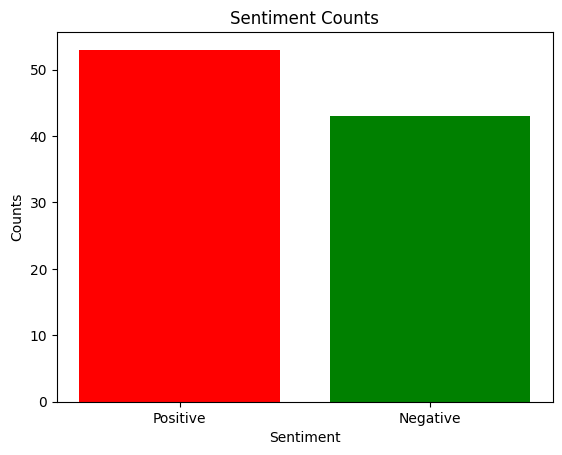

In [234]:
sentiment_counts = customer_feedback['Sentiment'].value_counts()

# Plotting the sentiment counts as a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])

# Adding titles and labels
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

# Displaying the plot
plt.show()

## Word Analysis

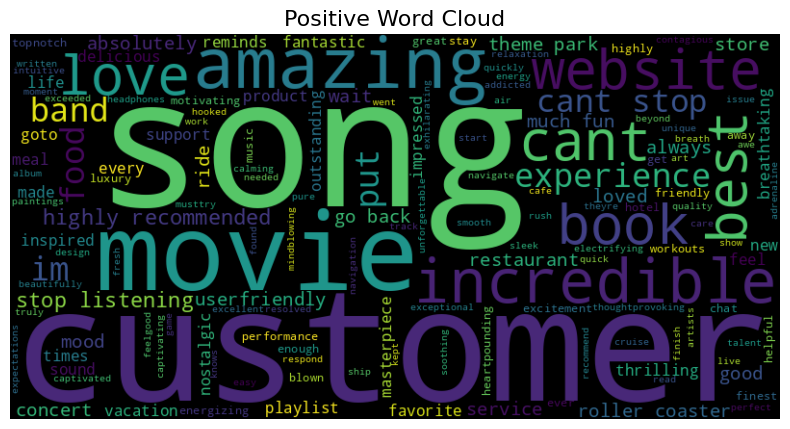

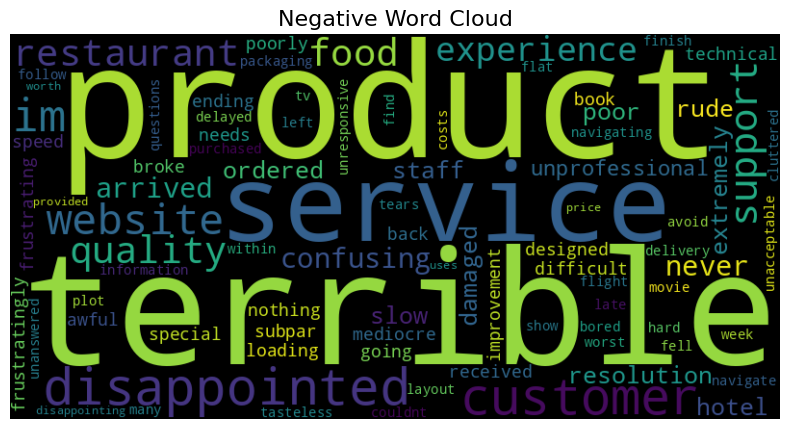

In [235]:
# Separate positive and negative reviews
positive_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Positive']['Cleaned_Text'])
negative_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Negative']['Cleaned_Text'])

# Stopwords
stop_words = set(stopwords.words('english'))

# Generate word clouds
def plot_wordcloud(text, title, stopwords):
    if not text.strip():  
        print(f"No words to generate a word cloud for: {title}")
        return
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='black',
        stopwords=stopwords,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Plot word clouds for positive and negative reviews
plot_wordcloud(positive_text, "Positive Word Cloud", stop_words)
plot_wordcloud(negative_text, "Negative Word Cloud", stop_words)

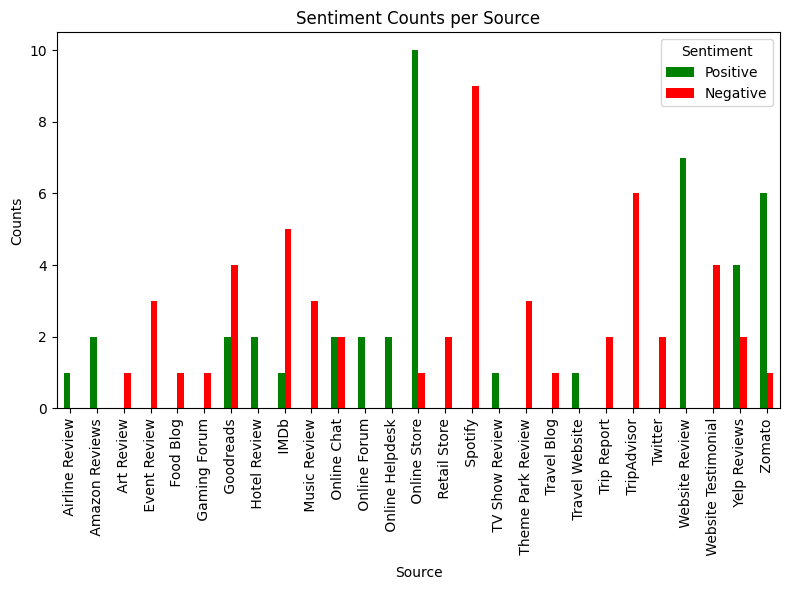

In [236]:
# Analysing Number of Positive and Negative Feedback Per Source
# Grouping data by 'Source' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Source', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Counts per Source')
plt.xlabel('Source')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()

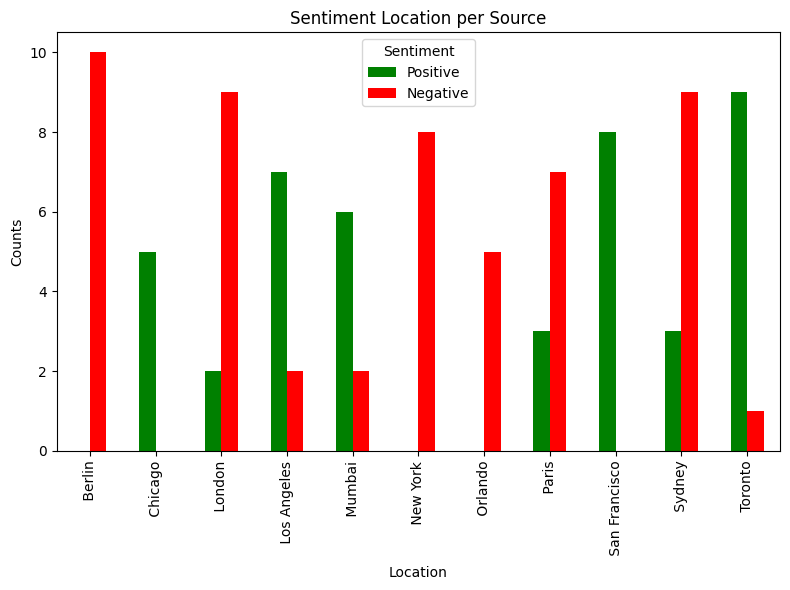

In [237]:
# Analysing Number of Positive and Negative Feedback Per Location
# Grouping data by 'Location' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()

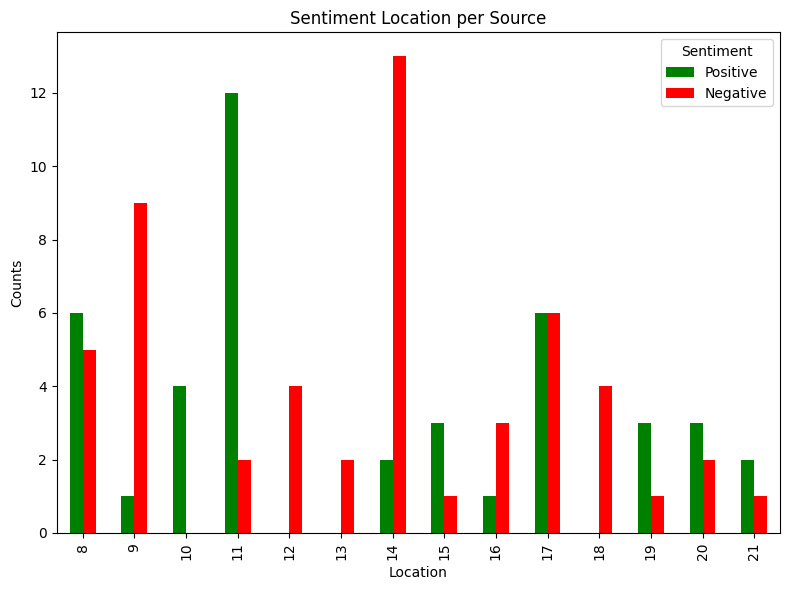

In [238]:
# Ensure the column is in datetime format
customer_feedback['Time'] = pd.to_datetime(customer_feedback['Date/Time'])

# Extract the start of the hour (only the hour component)
customer_feedback['Hour'] = customer_feedback['Time'].dt.hour

# Analysing Number of Positive and Negative Feedback Per Hour
# Grouping data by 'Hour' and 'Sentiment' and counting occurrences
sentiment_counts = customer_feedback.groupby(['Hour', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the sentiment counts as a bar chart
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))

# Adding titles and labels
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])

# Displaying the plot
plt.tight_layout()
plt.show()

## Modeling : BERT
**BERT (Bidirectional Encoder Representations from Transformers)**

- Captures context in both directions (left-to-right and right-to-left).
- State-of-the-art for many NLP tasks, including sentiment analysis.
- Pretrained versions like bert-base-uncased can be fine-tuned on your dataset.

### Why Split First?
- **Avoid Data Leakage:** If you tokenize the entire dataset first and then split it, you risk leaking information from the validation set into the training set. This could result in overestimated performance during validation.
- **Ensures Fair Evaluation:** Splitting the raw data ensures that your validation set remains unseen during training, which is crucial for evaluating the model's generalization.

### Improvements
I noticed since the dataset is small some of the good statements are geting prdicted as Negative thence I am adding those sentences to the test dataset

### Tokenize the Text and Creating PyTorch Datasets

An **AutoTokenizer** is a utility from the Hugging Face Transformers library designed for ease of use when working with a variety of transformer-based models. It provides a simple way to instantiate a tokenizer corresponding to a pre-trained model, without needing to manually select the appropriate tokenizer class (e.g., BertTokenizer, RobertaTokenizer).

**How it Works:**\
The AutoTokenizer class automatically determines the correct tokenizer class to use based on the model's name or configuration.

**Key Features:**
- Dynamic Class Selection: Automatically identifies the correct tokenizer class for the specified model.
- Flexibility: Works with any model that has a corresponding tokenizer in the Transformers library.
- Pre-Trained Support: Easily loads pre-trained tokenizers from the Hugging Face Model Hub.
- Custom Tokenizer: Allows loading custom tokenizer files.

**Why Use AutoTokenizer?**
- Convenience: No need to memorize or hard-code the specific tokenizer class for each model.
- Consistency: Ensures the correct tokenizer is paired with its model.
- Extensibility: Handles different models seamlessly, which is especially useful in pipelines or dynamic applications.

## Combad Overfitting
- **Dropout:** Add dropout layers to prevent overfitting.
   - A dropout layer is a regularization technique in deep learning that randomly deactivates a percentage of neurons during training to help prevent overfitting.
- **Weight Decay:** Use weight decay for L2 regularization during optimization.
   -  Weight decay, also known as regularization, is a technique used to train neural networks by penalizing large weights.

In [239]:
import pandas as pd
import random

# Define a dictionary of synonyms for positive and negative words
synonym_dict = {
    'Positive': ['it is good', 'great', 'fantastic', 'awesome', 'love', 'amazing', 'wonderful', 'excellent'],
    'Negative': ['bad', 'horrible', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'lousy']
}

customer_feedback = customer_feedback[['Sentiment', 'Cleaned_Text']]

# Create a list to store the data
df = []

# Add positive examples to the data list
for text in synonym_dict['Positive']:
    df.append([text, 'Positive'])

# Add negative examples to the data list
for text in synonym_dict['Negative']:
    df.append([text, 'Negative'])

# Create a DataFrame from the data list
df = pd.DataFrame(df, columns=['Cleaned_Text', 'Sentiment'])

# Append the newly created DataFrame to the original customer_feedback DataFrame
customer_feedback = pd.concat([customer_feedback, df], ignore_index=True)


In [240]:
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    customer_feedback['Cleaned_Text'], customer_feedback['Sentiment'], test_size=0.2, random_state=42
)

# Map the labels to numerical values (0 for Negative, 1 for Positive)
train_labels = train_labels.map({'Negative': 0, 'Positive': 1})
test_labels = test_labels.map({'Negative': 0, 'Positive': 1})

# Tokenize the training data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_inputs = tokenizer(
    list(train_texts),  # Ensure train_texts is a list
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

# Tokenize testing data
test_inputs = tokenizer(
    list(test_texts),  # Ensure test_texts is a list
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

# Define the number of labels for classification
num_labels = 2

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Convert tokenized inputs and labels into a TensorDataset for training
train_dataset = TensorDataset(
    train_inputs['input_ids'],
    train_inputs['attention_mask'],
    torch.tensor(train_labels.values, dtype=torch.long)  # Ensure labels are torch tensors of integers
)

# Create DataLoader for training
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(
    test_inputs['input_ids'],
    test_inputs['attention_mask'],
    torch.tensor(test_labels.values, dtype=torch.long)  # Ensure test labels are torch tensors
)

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the Model

### Ideal Loss Range Based on Epochs:
- **0.7–0.6 (Epoch 1-2):** Early training, model learns basic features.
- **0.5–0.4 (Epoch 3-5):** Training progresses, the model is fine-tuning.
- **0.3–0.2 (Epoch 6-10):** This is where you should ideally aim to be. If the loss keeps decreasing, you’re on the right track.
- **< 0.2:** Excellent, indicating your model is learning well.

### Monitoring Overfitting:
- **Validation Loss:** Track the validation loss as well. A model that improves on the training set but not on the validation set is overfitting.
- **Early Stopping:** Implement early stopping if the validation loss doesn't improve after several epochs to avoid overfitting.

In [241]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)

# Initialize variables for early stopping and training loss tracking
best_train_loss = float('inf')
counter = 0
patience = 3  # Number of epochs without improvement before early stopping
epochs = 6

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for batch in train_dataloader:  # Iterate through the DataLoader
        input_ids, attention_mask, labels = batch  # Unpack the batch into individual components

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Print the average training loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}")

    # Early stopping based on training loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping due to no improvement in training loss.")
            break

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6, Training Loss: 0.7124843001365662
Epoch 2/6, Training Loss: 0.6984156966209412
Epoch 3/6, Training Loss: 0.6911071042219797
Epoch 4/6, Training Loss: 0.6377568344275156
Epoch 5/6, Training Loss: 0.6207706530888876
Epoch 6/6, Training Loss: 0.5743333001931509


## Model Evaluation

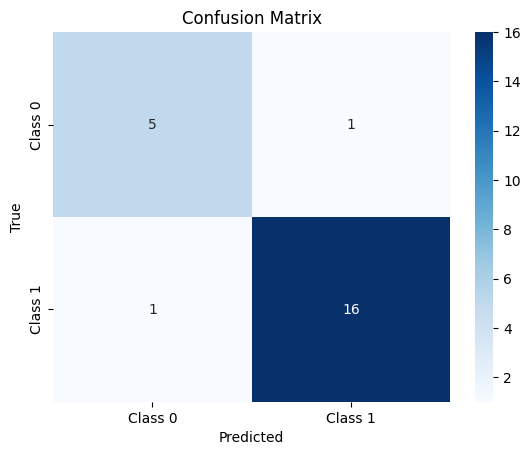

Test Accuracy: 0.9130
              precision    recall  f1-score   support

     Class 0       0.83      0.83      0.83         6
     Class 1       0.94      0.94      0.94        17

    accuracy                           0.91        23
   macro avg       0.89      0.89      0.89        23
weighted avg       0.91      0.91      0.91        23



In [242]:
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the device to CUDA if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize lists for storing true labels and predicted labels
all_labels = []
all_preds = []

correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        # Unpack the batch correctly (tuple of input_ids, attention_mask, labels)
        input_ids, attention_mask, labels = batch
        
        # Move tensors to the same device as the model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted_labels.cpu().numpy())

        # Calculate accuracy
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy:.4f}")

# Generate the classification report
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


## Predicting with user input

In [243]:
# Function to make predictions on a single user input text
def predict_user_input(user_input):
    # Tokenize the user input text
    inputs = tokenizer(
        user_input,                       # Single text input
        padding=True,                      # Pad to max length
        truncation=True,                   # Truncate if length exceeds max_length
        return_tensors="pt",               # Return PyTorch tensors
        max_length=512                     # Ensure max length for BERT
    )
    
    # Move inputs to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()  # Get the predicted class index
    
    # Map the predicted label to the corresponding sentiment
    predicted_class = 'Positive' if predicted_label == 1 else 'Negative'
    
    return predicted_class

In [249]:
# Example user input for prediction
user_input = input("Enter text for sentiment classification: ")

# Predict the sentiment for the user input
predicted_class = predict_user_input(user_input)

# Display the result
print(f"Predicted Sentiment: {predicted_class}")


Enter text for sentiment classification:  Bad


Predicted Sentiment: Negative
